In [1]:
import pandas as pd

In [2]:
# 통합 파일 불러오기
integrated_data = pd.read_csv('clustered_data.csv')

In [5]:
# 원본 파일 불러오기
original_data = pd.read_csv('dataset_80.csv')

In [6]:
# 유저 아이디를 기준으로 두 파일 합치기
merged_data = pd.merge(integrated_data, original_data, on='UserID')

In [7]:
# 결과 확인
print(merged_data)

        UserID  CheckIn  LocationFrequency  ActivityTime  Cluster  \
0            1      101                 46            15        0   
1            1      101                 46            15        0   
2            1      101                 46            15        0   
3            1      101                 46            15        0   
4            1      101                 46            15        0   
...        ...      ...                ...           ...      ...   
170241    1083      216                 32            13        0   
170242    1083      216                 32            13        0   
170243    1083      216                 32            13        0   
170244    1083      216                 32            13        0   
170245    1083      216                 32            13        0   

                        Venue ID         Venue category ID  \
0       4abc1f51f964a520798620e3  4bf58dd8d48988d1ce941735   
1       4d4ac10da0ef54814b6ffff6  4bf58dd8d4898

In [8]:
# 합친 데이터를 파일로 저장
merged_data.to_csv('integrated_data.csv', index=False)

클러스터1(액티브),  0(인액티브) 파일 저장

In [9]:
# 합친 데이터 불러오기
merged_data = pd.read_csv('integrated_data.csv')

In [10]:
# 클러스터 1 (액티브) 파일 저장
active_users = merged_data[merged_data['Cluster'] == 1]
active_users.to_csv('active_users_total.csv', index=False)

In [11]:
# 클러스터 0 (인액티브) 파일 저장
inactive_users = merged_data[merged_data['Cluster'] == 0]
inactive_users.to_csv('inactive_users_total.csv', index=False)

패턴분석

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

In [21]:
# 데이터 불러오기
data = pd.read_csv('integrated_data.csv')

시간대별 우세 카테고리

In [22]:
# 시간대별 category name 빈도수 계산
time_category = data.groupby(['UTC time', 'Venue category name']).size().unstack()

1시간 간격으로 우세 카테고리

In [23]:
# 1. datetime 열을 datetime 자료형으로 변환
data['datetime'] = pd.to_datetime(data['UTC time'])

In [24]:
# 2. 시간(hour) 정보 추출
data['hour'] = data['datetime'].dt.hour

In [25]:
# 3. 1시간 단위로 데이터 그룹화 후, 카테고리별 체크인 수 계산
hourly_category_counts = data.groupby(['hour', 'Venue category name'])['Venue ID'].count()

In [26]:
hourly_category_counts

hour  Venue category name  
0     Afghan Restaurant          1
      African Restaurant         2
      Airport                  101
      American Restaurant      272
      Arcade                    26
                              ... 
23    Video Store                1
      Vietnamese Restaurant     17
      Winery                     2
      Wings Joint               16
      Zoo                        1
Name: Venue ID, Length: 4466, dtype: int64

In [29]:
# 각 시간대별로 가장 많이 등장한 카테고리 상위 3개 추출
top5 = data.groupby(['hour', 'Venue category name'])['UserID'].count().reset_index()
top5 = top5.sort_values(['hour', 'UserID'], ascending=[True, False])
top5 = top5.groupby('hour').head(5)
top5 = top5.pivot(index='hour', columns='Venue category name', values='UserID')
top5 = top5.fillna(0)
top5 = top5.astype(int)

In [31]:
# 1시간 단위로 데이터 그룹화
grouped_data = data.groupby(["hour", "Venue category name"]).size().reset_index(name="count")

In [33]:
# 시간대별로 가장 많이 나온 카테고리 3개 추출

top_categories = []
for hour in range(24):
    # 해당 시간대의 데이터만 추출
    hour_data = grouped_data[grouped_data["hour"] == hour]
    # 카테고리별로 count 기준 내림차순 정렬 후 상위 3개만 추출
    top_categories_hour = hour_data.groupby("Venue category name").sum().sort_values("count", ascending=False).head(5)
    top_categories.append(top_categories_hour.index.tolist())

In [34]:
# 결과 출력
for hour, categories in enumerate(top_categories):
    print("Hour {}: {}".format(hour, ", ".join(categories)))

Hour 0: Bar, Home (private), Subway, Gym / Fitness Center, Food & Drink Shop
Hour 1: Bar, Home (private), Subway, American Restaurant, Residential Building (Apartment / Condo)
Hour 2: Bar, Home (private), Subway, Residential Building (Apartment / Condo), American Restaurant
Hour 3: Bar, Home (private), Subway, Residential Building (Apartment / Condo), Neighborhood
Hour 4: Bar, Home (private), Subway, Residential Building (Apartment / Condo), Bus Station
Hour 5: Bar, Home (private), Subway, Residential Building (Apartment / Condo), Other Great Outdoors
Hour 6: Bar, Home (private), Hotel, Other Great Outdoors, Deli / Bodega
Hour 7: Home (private), Bar, Residential Building (Apartment / Condo), Deli / Bodega, Subway
Hour 8: Home (private), Subway, Bar, Road, Airport
Hour 9: Home (private), Gym / Fitness Center, Subway, Airport, Deli / Bodega
Hour 10: Gym / Fitness Center, Subway, Home (private), Bus Station, Coffee Shop
Hour 11: Subway, Office, Home (private), Coffee Shop, Gym / Fitness C

카테고리 결과 시각화

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

In [36]:
# 시간대별, 카테고리별 방문 빈도수 계산
freq = data.groupby(['hour', 'Venue category name'])['Venue category name'].count().reset_index(name='count')

In [37]:
# 시간대별로 가장 많이 방문한 카테고리 상위 3개 추출
top5 = freq.groupby('hour').apply(lambda x: x.nlargest(5, columns=['count'])).reset_index(drop=True)

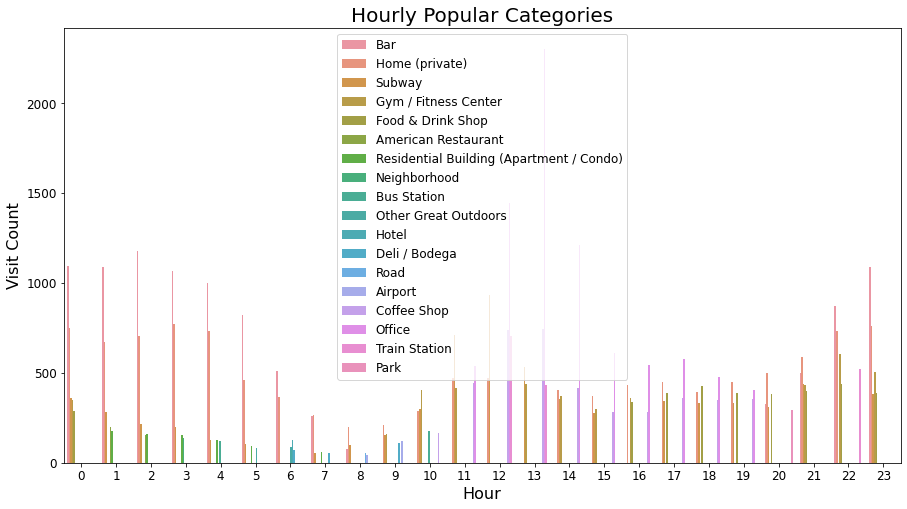

In [39]:
# 그래프 그리기
plt.figure(figsize=(15, 8))
sns.barplot(x='hour', y='count', hue='Venue category name', data=top5)
plt.title("Hourly Popular Categories", fontsize=20)
plt.xlabel("Hour", fontsize=16)
plt.ylabel("Visit Count", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.show()

대중장소 삭제

In [48]:
# 삭제할 항목 리스트 생성
words_to_remove = ['Office', 'Home (private)','private' ,'Train Station', 'Bank', 'Subway', 'Hotel', 'Gym / Fitness Center', 
                        'Road', 'Medical Center', 'Building', 'Financial or Legal Service', 'Airport', 'Hardware Store', 
                        'Airport', 'Post Office', 'Gas Station / Garage', 'Drugstore / Pharmacy', 'Athletic & Sport', 
                        'Neighborhood', 'Electronics Store', 'Mobile Phone Shop', 'Automotive Shop', 'Parking', 'Clothing Store',
                        'Bus Station']

In [49]:
# 특정 단어를 포함하는 카테고리 삭제
for word in words_to_remove:
    data = data[~data['Venue category name'].str.contains(word)]

c:\ProgramData\Anaconda3\lib\site-packages\pandas\core\strings\accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [50]:
# 결과를 파일로 저장
data.to_csv('filtered_data.csv', index=False)